 # Notebook 21: Ensemble Topic Classification

 ## Purpose
 - Apply multiple topic classification methods to articles
 - Compare keyword-based, LDA, K-means clustering approaches
 - Generate ensemble consensus topic labels
 - Integrate with existing bias analysis pipeline

 ## Source
 This notebook integrates functionality from `scripts/catogorise_the_article.py`
 and `scripts/lda_topic_classification.py` into the notebook workflow.

 ## Inputs
 - `data/processed/articles_cleaned_sample_30000.csv` (or any preprocessed articles)

 ## Outputs
 - `data/processed/articles_with_topics_sample_30000.parquet`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import os
import pickle
import joblib
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [2]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
MODEL_DIR = BASE_DIR / 'notebooks' / 'lda_model'

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

INPUT_FILE = PROCESSED_DIR / 'articles_cleaned.csv'
OUTPUT_FILE = PROCESSED_DIR / 'articles_with_topics.parquet'

 ## 1. Text Preprocessing

In [3]:
def preprocess_text(text: str) -> str:
    """Clean and preprocess text for topic modeling."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    tokens = re.findall(r"[a-z]+", text)
    stop_words = ENGLISH_STOP_WORDS
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)


print("Preprocessing function defined")

Preprocessing function defined


 ## 2. Topic Keywords Dictionary

In [4]:
TOPIC_KEYWORDS = {
    'politics': [
        'government', 'policy', 'political', 'minister', 'election',
        'parliament', 'ruling', 'opposition', 'congress', 'bjp',
        'vote', 'democracy', 'law', 'legislation', 'cabinet'
    ],
    'sports': [
        'cricket', 'match', 'stadium', 'team', 'player', 'olympic',
        'training', 'sports', 'score', 'tournament', 'league',
        'championship', 'win', 'defeat', 'captain'
    ],
    'technology': [
        'technology', 'software', 'digital', 'startup', 'innovation',
        'tech', 'platform', 'data', 'ai', 'artificial', 'intelligence',
        'app', 'mobile', 'internet', 'cyber'
    ],
    'entertainment': [
        'movie', 'bollywood', 'film', 'entertainment', 'box office',
        'streaming', 'cultural', 'actor', 'actress', 'director',
        'music', 'album', 'celebrity', 'award'
    ],
    'business': [
        'stock', 'market', 'economic', 'business', 'growth', 'budget',
        'financial', 'economy', 'investment', 'company', 'profit',
        'revenue', 'trade', 'gdp', 'inflation'
    ],
    'health': [
        'health', 'medical', 'healthcare', 'covid', 'vaccination',
        'hospital', 'treatment', 'disease', 'doctor', 'patient',
        'medicine', 'virus', 'pandemic', 'symptoms'
    ],
    'education': [
        'education', 'learning', 'school', 'student', 'university',
        'skill', 'educational', 'exam', 'college', 'teacher',
        'curriculum', 'degree', 'academic'
    ],
    'environment': [
        'environment', 'climate', 'renewable', 'energy', 'clean',
        'pollution', 'green', 'carbon', 'sustainable', 'conservation',
        'wildlife', 'forest', 'emissions'
    ],
    'infrastructure': [
        'infrastructure', 'highway', 'railway', 'construction',
        'development', 'project', 'road', 'bridge', 'metro',
        'airport', 'port', 'smart city'
    ],
    'social': [
        'social', 'festival', 'community', 'cultural', 'religious',
        'harmony', 'celebration', 'tradition', 'society', 'welfare',
        'rural', 'urban', 'poverty'
    ]
}

print(f"Defined {len(TOPIC_KEYWORDS)} topic categories")
for topic, keywords in TOPIC_KEYWORDS.items():
    print(f"  - {topic}: {len(keywords)} keywords")

Defined 10 topic categories
  - politics: 15 keywords
  - sports: 15 keywords
  - technology: 15 keywords
  - entertainment: 14 keywords
  - business: 15 keywords
  - health: 14 keywords
  - education: 13 keywords
  - environment: 13 keywords
  - infrastructure: 12 keywords
  - social: 13 keywords


 ## 3. Keyword-based Classification

In [5]:
def keyword_classification(text: str, topic_keywords: dict = TOPIC_KEYWORDS) -> tuple:
    """
    Classify article based on keyword matching.

    Returns:
        tuple: (topic, confidence_score)
    """
    if not text:
        return 'unknown', 0.0

    text_lower = text.lower()
    scores = {}

    for topic, keywords in topic_keywords.items():
        matches = sum(1 for kw in keywords if kw in text_lower)
        if matches > 0:
            scores[topic] = matches / len(keywords)

    if scores:
        best_topic = max(scores, key=scores.get)
        return best_topic, scores[best_topic]

    return 'unknown', 0.0


def apply_keyword_classification(df: pd.DataFrame, text_column: str = 'text_for_analysis') -> pd.DataFrame:
    """Apply keyword classification to all articles."""
    topics = []
    confidences = []

    for text in df[text_column]:
        topic, conf = keyword_classification(text)
        topics.append(topic)
        confidences.append(conf)

    df['keyword_topic'] = topics
    df['keyword_confidence'] = confidences

    return df


print("Keyword classification functions defined")

Keyword classification functions defined


 ## 4. LDA Topic Modeling

In [6]:
def train_lda_model(texts, n_topics=10, max_features=200):
    """
    Train LDA topic model.

    Args:
        texts: List of preprocessed texts
        n_topics: Number of topics to extract
        max_features: Maximum vocabulary size

    Returns:
        lda: Fitted LDA model
        vectorizer: CountVectorizer
        doc_topic_dist: Document-topic distribution
        topic_words: Top words per topic
    """
    print(f"Training LDA with {n_topics} topics...")

    # Vectorize
    vectorizer = CountVectorizer(
        max_df=0.8,
        min_df=2,
        max_features=max_features,
        ngram_range=(1, 2)
    )

    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Train LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=100,
        n_jobs=-1  # Use all cores
    )

    lda.fit(doc_term_matrix)

    # Extract topic words
    topic_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_words.append(top_words)

    # Get document-topic distribution
    doc_topic_dist = lda.transform(doc_term_matrix)

    print("LDA training complete")
    return lda, vectorizer, doc_topic_dist, topic_words


def apply_lda_topics(df: pd.DataFrame, doc_topic_dist: np.ndarray) -> pd.DataFrame:
    """Apply LDA topic assignments to dataframe."""
    df['lda_topic'] = np.argmax(doc_topic_dist, axis=1)
    df['lda_confidence'] = np.max(doc_topic_dist, axis=1)
    return df


print("LDA functions defined")

LDA functions defined


 ## 5. TF-IDF + K-Means Clustering

In [7]:
def tfidf_kmeans_clustering(texts, n_clusters=10):
    """
    Cluster articles using TF-IDF + K-Means.

    Args:
        texts: List of preprocessed texts
        n_clusters: Number of clusters

    Returns:
        kmeans: Fitted KMeans model
        tfidf_vectorizer: TfidfVectorizer
        cluster_labels: Cluster assignments
    """
    print(f"Running TF-IDF + K-Means with {n_clusters} clusters...")

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        max_features=200,
        ngram_range=(1, 2),
        stop_words='english'
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    print("Clustering complete")
    return kmeans, tfidf_vectorizer, cluster_labels


print("Clustering functions defined")

Clustering functions defined


 ## 6. Ensemble Topic Classifier

In [8]:
class EnsembleTopicClassifier:
    """Combine multiple topic classification methods."""

    def __init__(self, topic_keywords=TOPIC_KEYWORDS):
        self.topic_keywords = topic_keywords

    def classify_article(self, text: str) -> dict:
        """Get topic predictions from multiple methods."""
        results = {}

        # Method 1: Keyword-based
        results['keywords'] = self._keyword_classification(text)

        # Method 2: Rule-based (more specific rules)
        results['rules'] = self._rule_based_classification(text)

        # Method 3: TF-IDF similarity (simplified)
        results['tfidf'] = self._tfidf_classification(text)

        return results

    def _keyword_classification(self, text: str) -> str:
        """Keyword-based classification."""
        text_lower = text.lower()

        scores = {}
        for topic, keywords in self.topic_keywords.items():
            matches = sum(1 for kw in keywords if kw in text_lower)
            if matches > 0:
                scores[topic] = matches

        if scores:
            return max(scores, key=scores.get)
        return 'other'

    def _rule_based_classification(self, text: str) -> str:
        """Rule-based classification with weighted terms."""
        text_lower = text.lower()

        # Domain-specific high-weight terms
        domain_terms = {
            'politics': ['minister', 'parliament', 'government', 'policy', 'election'],
            'sports': ['cricket', 'match', 'team', 'player', 'score'],
            'technology': ['software', 'digital', 'tech', 'startup', 'ai'],
            'business': ['market', 'economic', 'business', 'financial', 'stock'],
            'health': ['health', 'medical', 'healthcare', 'hospital', 'patient'],
            'education': ['education', 'school', 'university', 'student', 'exam']
        }

        scores = {topic: sum(1 for term in terms if term in text_lower)
                  for topic, terms in domain_terms.items()}

        if max(scores.values()) > 0:
            return max(scores, key=scores.get)
        return 'other'

    def _tfidf_classification(self, text: str) -> str:
        """Simple TF-IDF inspired classification."""
        words = set(text.lower().split())

        # Check for distinctive terms
        if words & {'government', 'minister', 'parliament', 'election'}:
            return 'politics'
        elif words & {'cricket', 'match', 'team', 'player', 'sports'}:
            return 'sports'
        elif words & {'technology', 'software', 'digital', 'tech', 'ai'}:
            return 'technology'
        elif words & {'business', 'market', 'economy', 'company'}:
            return 'business'
        elif words & {'health', 'medical', 'hospital', 'doctor'}:
            return 'health'
        else:
            return 'other'

    def get_consensus(self, results: dict) -> tuple:
        """Get consensus from multiple classification methods."""
        predictions = list(results.values())
        vote_counts = Counter(predictions)
        consensus = vote_counts.most_common(1)[0][0]
        confidence = vote_counts[consensus] / len(predictions)
        return consensus, confidence


def apply_ensemble_classification(df: pd.DataFrame, text_column: str = 'text_for_analysis') -> pd.DataFrame:
    """Apply ensemble topic classification to all articles."""
    classifier = EnsembleTopicClassifier()

    ensemble_topics = []
    ensemble_confidences = []

    for text in df[text_column]:
        results = classifier.classify_article(str(text))
        consensus, confidence = classifier.get_consensus(results)
        ensemble_topics.append(consensus)
        ensemble_confidences.append(confidence)

    df['ensemble_topic'] = ensemble_topics
    df['ensemble_confidence'] = ensemble_confidences

    return df


print("Ensemble classifier defined")

Ensemble classifier defined


 ## 7. Load Data

In [9]:
print("Loading data...")

# Try to load the cleaned data, or use a fallback
if INPUT_FILE.exists():
    df = pd.read_csv(INPUT_FILE)
    print(f"Loaded {len(df):,} articles from {INPUT_FILE.name}")
else:
    # Try alternative paths
    alt_paths = [
        PROCESSED_DIR / 'articles_with_events_sample_30000.csv',
        PROCESSED_DIR / 'raw_articles.csv',
        BASE_DIR / 'data' / 'raw' / 'articles.csv'
    ]

    for alt_path in alt_paths:
        if alt_path.exists():
            df = pd.read_csv(alt_path)
            print(f"Loaded {len(df):,} articles from {alt_path.name}")
            break
    else:
        raise FileNotFoundError(f"No input file found. Tried: {INPUT_FILE} and alternatives")

# Determine text column
text_col = 'article_text_cleaned' if 'article_text_cleaned' in df.columns else 'article_text'
df['text_for_analysis'] = df[text_col].fillna('')

print(f"Using text column: {text_col}")
print(f"Columns: {list(df.columns)[:10]}...")

Loading data...
Loaded 49,926 articles from articles_cleaned.csv
Using text column: article_text_cleaned
Columns: ['url', 'title', 'author', 'published_date', 'published_date_parsed', 'publication_date', 'publication_year', 'publication_month', 'publication_day', 'modified_date']...


 ## 8. Preprocess Text

In [10]:
print("Preprocessing text for topic modeling...")
df['processed_text'] = df['text_for_analysis'].apply(preprocess_text)

# Check preprocessing results
sample_idx = df[df['processed_text'].str.len() > 100].index[0]
print(f"\nSample original ({len(df.loc[sample_idx, 'text_for_analysis'])} chars):")
print(df.loc[sample_idx, 'text_for_analysis'][:200], "...")
print(f"\nSample processed ({len(df.loc[sample_idx, 'processed_text'])} chars):")
print(df.loc[sample_idx, 'processed_text'][:200], "...")

Preprocessing text for topic modeling...

Sample original (3306 chars):
amazon great festival sale amazon upcoming great festival sale kick october continue till october sale retailer provide deals discounts leading smartphone brands consumers avail per cent discounts pur ...

Sample processed (3177 chars):
amazon great festival sale amazon upcoming great festival sale kick october continue till october sale retailer provide deals discounts leading smartphone brands consumers avail cent discounts purchas ...


 ## 9. Apply All Classification Methods

In [11]:
print("\n" + "=" * 60)
print("APPLYING TOPIC CLASSIFICATION METHODS")
print("=" * 60)

# Method 1: Keyword-based
print("\n1. Keyword-based classification...")
df = apply_keyword_classification(df, 'text_for_analysis')
print(f"   Distribution: {df['keyword_topic'].value_counts().head().to_dict()}")

# Method 2: LDA Topic Modeling
print("\n2. LDA Topic Modeling...")
try:
    lda_model, lda_vectorizer, doc_topics, topic_words = train_lda_model(
        df['processed_text'].tolist(),
        n_topics=10
    )
    df = apply_lda_topics(df, doc_topics)

    print("\n   LDA Topic Words:")
    for i, words in enumerate(topic_words):
        print(f"   Topic {i}: {', '.join(words[:5])}...")
except Exception as e:
    print(f"   LDA failed: {e}")
    df['lda_topic'] = -1
    df['lda_confidence'] = 0.0

# Method 3: TF-IDF + K-Means
print("\n3. TF-IDF + K-Means clustering...")
try:
    kmeans_model, tfidf_vec, cluster_labels = tfidf_kmeans_clustering(
        df['processed_text'].tolist(),
        n_clusters=10
    )
    df['cluster_topic'] = cluster_labels
    print(f"   Cluster distribution: {Counter(cluster_labels).most_common(5)}")
except Exception as e:
    print(f"   Clustering failed: {e}")
    df['cluster_topic'] = -1

# Method 4: Ensemble Classification
print("\n4. Ensemble classification...")
df = apply_ensemble_classification(df, 'text_for_analysis')
print(f"   Distribution: {df['ensemble_topic'].value_counts().head().to_dict()}")


APPLYING TOPIC CLASSIFICATION METHODS

1. Keyword-based classification...
   Distribution: {'sports': 10613, 'technology': 8676, 'politics': 8292, 'infrastructure': 7264, 'business': 5080}

2. LDA Topic Modeling...
Training LDA with 10 topics...
LDA training complete

   LDA Topic Words:
   Topic 0: business, latest, prime, updates, new...
   Topic 1: court, case, nthe, order, high...
   Topic 2: like, says, people, time, years...
   Topic 3: nthe, new, country, ministry, film...
   Topic 4: second, match, game, win, final...
   Topic 5: cent, market, bank, crore, budget...
   Topic 6: year, old, women, family, year old...
   Topic 7: police, nthe, district, people, students...
   Topic 8: pakistan, team, cricket, test, series...
   Topic 9: bjp, congress, singh, president, leader...

3. TF-IDF + K-Means clustering...
Running TF-IDF + K-Means with 10 clusters...
Clustering complete
   Cluster distribution: [(np.int32(3), 19771), (np.int32(9), 8018), (np.int32(6), 4917), (np.int32(2), 

 ## 10. Visualize Topic Distributions

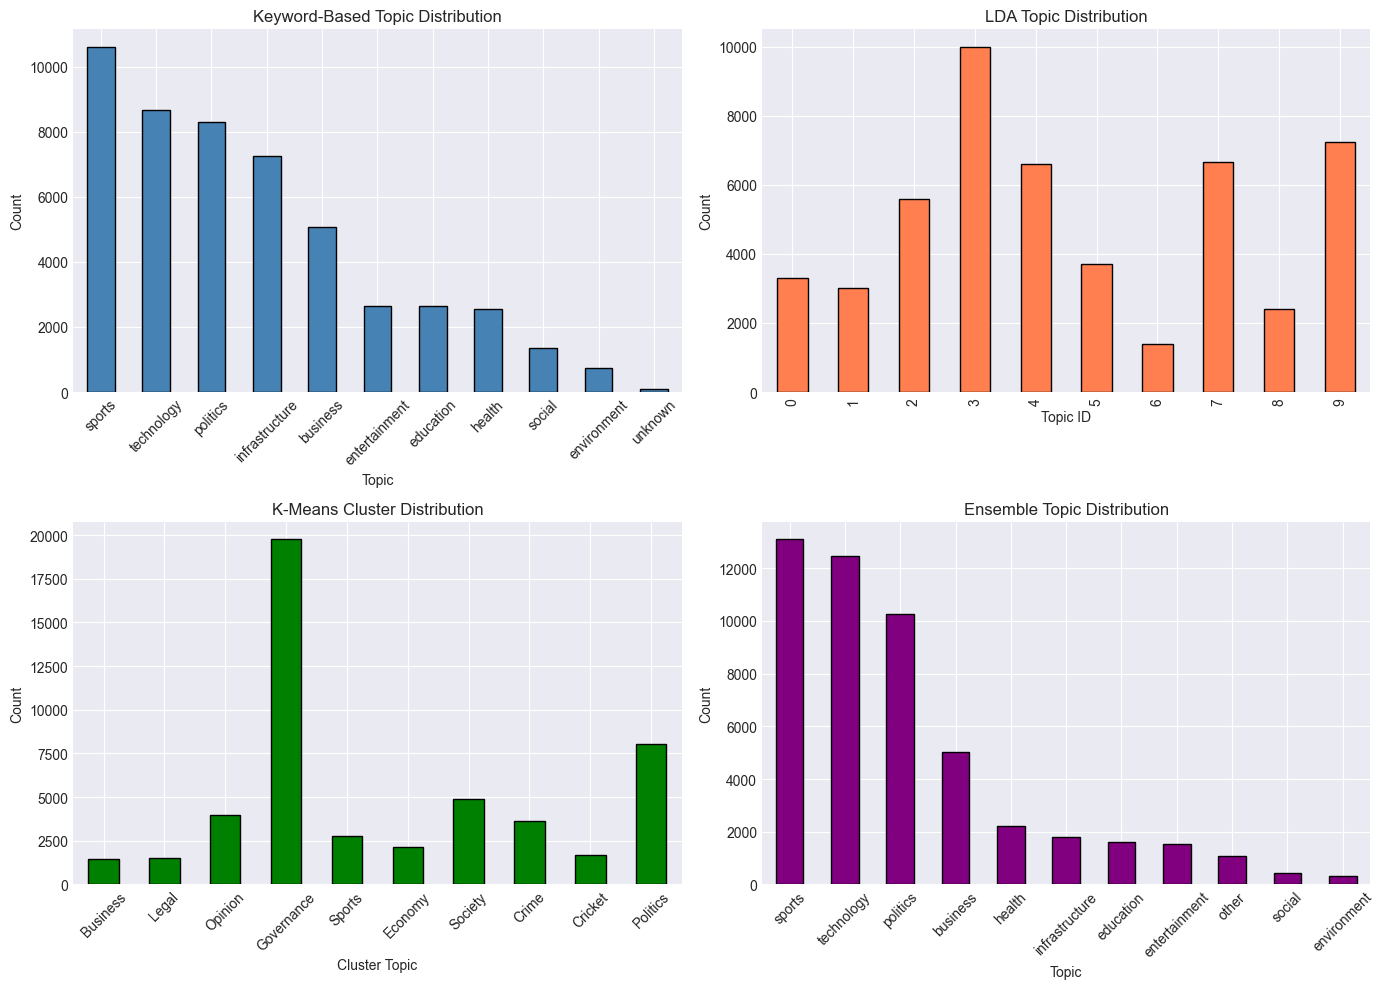

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Keyword-based topics
ax1 = axes[0, 0]
keyword_counts = df['keyword_topic'].value_counts()
keyword_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Keyword-Based Topic Distribution')
ax1.set_xlabel('Topic')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# LDA topics
ax2 = axes[0, 1]
if 'lda_topic' in df.columns and df['lda_topic'].max() >= 0:
    lda_counts = df['lda_topic'].value_counts().sort_index()
    lda_counts.plot(kind='bar', ax=ax2, color='coral', edgecolor='black')
    ax2.set_title('LDA Topic Distribution')
    ax2.set_xlabel('Topic ID')
    ax2.set_ylabel('Count')

# Cluster topics (K-Means) with descriptive labels
ax3 = axes[1, 0]
if 'cluster_topic' in df.columns and df['cluster_topic'].max() >= 0:
    cluster_counts = df['cluster_topic'].value_counts().sort_index()

    # Map numeric cluster IDs to descriptive topic names
    cluster_topic_names = {
        0: 'Business',
        1: 'Legal',
        2: 'Opinion',
        3: 'Governance',
        4: 'Sports',
        5: 'Economy',
        6: 'Society',
        7: 'Crime',
        8: 'Cricket',
        9: 'Politics',
    }
    cluster_counts.index = cluster_counts.index.map(cluster_topic_names)

    cluster_counts.plot(kind='bar', ax=ax3, color='green', edgecolor='black')
    ax3.set_title('K-Means Cluster Distribution')
    ax3.set_xlabel('Cluster Topic')
    ax3.set_ylabel('Count')
    ax3.tick_params(axis='x', rotation=45)

# Ensemble topics
ax4 = axes[1, 1]
ensemble_counts = df['ensemble_topic'].value_counts()
ensemble_counts.plot(kind='bar', ax=ax4, color='purple', edgecolor='black')
ax4.set_title('Ensemble Topic Distribution')
ax4.set_xlabel('Topic')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Key insights: Topic distributions across methods

1) Sports, technology, and politics dominate coverage, appearing as the largest categories in both keyword-based and ensemble topic distributions, while social and environment remain relatively underrepresented.

2) K‑Means clusters are highly imbalanced, with a very large Governance cluster and smaller clusters like Legal and Crime, suggesting that governance-related language is widespread and that unsupervised clustering groups many diverse articles under this theme.

 ## 11. Compare Classification Methods

In [13]:
print("\n" + "=" * 60)
print("CLASSIFICATION METHOD COMPARISON")
print("=" * 60)

# Agreement between methods
if df['keyword_topic'].nunique() > 1 and df['ensemble_topic'].nunique() > 1:
    agreement = (df['keyword_topic'] == df['ensemble_topic']).mean()
    print(f"\nKeyword vs Ensemble agreement: {agreement:.1%}")

# Confidence distributions
print("\nConfidence Score Statistics:")
print(f"  Keyword confidence: mean={df['keyword_confidence'].mean():.3f}, median={df['keyword_confidence'].median():.3f}")
if 'lda_confidence' in df.columns:
    print(f"  LDA confidence: mean={df['lda_confidence'].mean():.3f}, median={df['lda_confidence'].median():.3f}")
print(f"  Ensemble confidence: mean={df['ensemble_confidence'].mean():.3f}, median={df['ensemble_confidence'].median():.3f}")


CLASSIFICATION METHOD COMPARISON

Keyword vs Ensemble agreement: 75.6%

Confidence Score Statistics:
  Keyword confidence: mean=0.253, median=0.214
  LDA confidence: mean=0.598, median=0.571
  Ensemble confidence: mean=0.716, median=0.667


 ## 12. Save Results

In [14]:
# Select columns to save
topic_columns = [
    'keyword_topic', 'keyword_confidence',
    'lda_topic', 'lda_confidence',
    'cluster_topic',
    'ensemble_topic', 'ensemble_confidence'
]

# Keep original columns plus new topic columns
columns_to_save = [col for col in df.columns if col not in ['processed_text', 'text_for_analysis']]

print(f"\nSaving results to {OUTPUT_FILE}...")
df[columns_to_save].to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved {len(df):,} articles with topic classifications")
print(f"  File size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")

# Save LDA model if trained successfully
if 'lda_model' in dir() and lda_model is not None:
    model_save_dir = MODEL_DIR / 'latest'
    model_save_dir.mkdir(parents=True, exist_ok=True)

    joblib.dump(lda_model, model_save_dir / 'lda_model.pkl')
    joblib.dump(lda_vectorizer, model_save_dir / 'vectorizer.pkl')
    with open(model_save_dir / 'topic_words.pkl', 'wb') as f:
        pickle.dump(topic_words, f)

    print(f"LDA model saved to {model_save_dir}")


Saving results to ../data/processed/articles_with_topics.parquet...
Saved 49,926 articles with topic classifications
  File size: 132.94 MB
LDA model saved to ../notebooks/lda_model/latest


 ## 13. Summary

INPUT: 49,926 articles
OUTPUT: [../data/processed/articles_with_topics.parquet](../data/processed/articles_with_topics.parquet)

METHODS APPLIED:
- Keyword-based classification (10 topics)
- LDA Topic Modeling (10 topics)
- TF-IDF + K-Means Clustering (10 clusters)
- Ensemble Classification (consensus voting)

TOPIC DISTRIBUTION (Ensemble):

| Topic | Count | Percentage |
|-------|-------|------------|
| sports | 13,105 | 26.2% |
| technology | 12,480 | 25.0% |
| politics | 10,250 | 20.5% |
| business | 5,022 | 10.1% |
| health | 2,227 | 4.5% |
| infrastructure | 1,812 | 3.6% |
| education | 1,613 | 3.2% |
| entertainment | 1,551 | 3.1% |
| other | 1,091 | 2.2% |
| social | 438 | 0.9% |
| environment | 337 | 0.7% |